**Table of Contents:** <br>
**A**. Importing Packages <br>
**B**. Loading Data <br>
**C**. Cleaning <br>
**D**. Candidate Relation <br>
**E**. Tweet Sentiment Score <br>
**F**. Parsing Through Data <br>
**G**. Sentiment Analysis <br>
**H**. Supporter Prediction <br>
**I**. Candidate Popularity Over Time <br>
**J**. Most Common Words for Each Candidate <br> 

**A. Importing Packages**

In [ ]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline


**B. Loading Data**

In [ ]:
#Tweets sample Data Frame.

Tweets = pd.read_csv("us_election_tweets.csv")

#Loading stop_words text.

swords = open('stop_words.txt')
swords_read = swords.read()

#Loading corpus text.

corpus_collumns = ["word", "value"]
corpus = pd.read_table('corpus.txt', names = corpus_collumns)

#Loading the Sample Tweets

tweets = pd.read_table("us_election_tweets.csv", lineterminator="\n", sep=",")

**C. Cleaning**

In [ ]:
#Lower case function

def lower_tweet(tw):
  tw = str (tw)
  ltw = tw.strip().lower()
  return (ltw)

#Cleaning tweet, removing punctuations.

def clean_tweet(tw):
  punctuation = """"!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""
  new_tweet = ""
  for i in tw:
    if i not in punctuation:
      new_tweet = new_tweet + i
    else:
      new_tweet = new_tweet + " "
  return (new_tweet)

#Removing stop words.

def stop_words(tw):
  tw = tw.split(" ")
  relevant_words = []
  for i in tw:
    if i not in swords_read:
      relevant_words.append(i)
  return (relevant_words)
  
#Creating a bag of words.

def bag_of_words(tw):
  bag_set = set (tw)
  bag = {}
  for i in bag_set:
    bag[i] = (tw.count(i))
  bag_data_frame = pd.DataFrame(bag, index = ["Count"])
  return (bag_data_frame)

**D. Candidate Relation**

In [ ]:
#Determining if it is about Trump, Biden, Both or None.

def candidate_relation(tw):
  Trump_signal = "trump" in tw
  Biden_signal = "biden" in tw
  if Trump_signal == True and Biden_signal == True:
    return ("Both")
  elif Trump_signal == True and Biden_signal == False:
    return ("Trump")
  elif Trump_signal == False and Biden_signal == True:
    return ("Biden")
  else:
    return ("None")

#Final Relation Function

def crelation(tw):
  Cand_relation = (candidate_relation(stop_words(clean_tweet(lower_tweet(tw)))))
  return (Cand_relation)

**E. Tweet Sentiment Score**

In [ ]:
#Determining the tweet score.

def tweet_score(tw):
  positive = 0
  negative = 0
  signal = 0
  for column in tw: 
    if column in corpus.values:
      j = (int(corpus[corpus["word"]==column].index.values))
      if (corpus.loc[j, "value"])<0:
        negative = negative + ((corpus.loc[j, "value"])*tw.loc["Count",column])
      elif (corpus.loc[j, "value"])>0:
        positive = positive +((corpus.loc[j, "value"])*tw.loc["Count",column])
      signal = 1
  if signal == 0:
    score = -1
  else:
    score = positive/((negative * (-1)) + positive)
  return (score)

#Final Tweet Score Function

def twscore(tw):
  Tw_score = (tweet_score(bag_of_words(stop_words(clean_tweet(lower_tweet(tw))))))
  return (Tw_score)

**F. Parsing Through Data**

In [ ]:
#Creating empty data frame for user_id, score, relation, and date

final_col = ["user_id", "Score", "Relation", "Date"]

final = pd.DataFrame(columns=final_col)

#Iterating throught the tweets and entering into the data frame

for i in tweets.index:
  tuser_id = tweets["user_id"][i]
  tscore = twscore(tweets["tweet"][i])
  trelation = crelation(tweets["tweet"][i])
  tdate = tweets["date"][i]
  
  bag = bags(tweets["tweet"][i])
  if trelation == 'Trump':
    trump_bag = trump_bag.add(bag, fill_value=False)
  elif trelation == 'Biden':
    biden_bag = biden_bag.add(bag, fill_value=False)

  entry = [tuser_id, tscore, trelation, tdate]
  final.loc[i] = entry

display(final)

#Saving results into a csv file
final.to_csv(r'processed_tweets.csv', index = True)

#Transposing the biden and trump word bags data frames for the bonus
trump_bag = pd.DataFrame.transpose(trump_bag)
biden_bag = pd.DataFrame.transpose(biden_bag)

#Saving trump and biden bags as csv files
trump_bag.to_csv(r'trump_bag.csv', index = True)
biden_bag.to_csv(r'biden_bag.csv', index = True)

#Reading processed data
final1 = pd.read_table("processed_tweets.csv", lineterminator="\n", sep=",")
trump_bag = pd.read_table("trump_bag.csv", lineterminator="\n", sep=",")
biden_bag = pd.read_table("biden_bag.csv", lineterminator="\n", sep=",")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,user_id,Score,Relation,Date
0,6.066668e+07,0.000000,None,10/28/2020
1,1.865321e+08,-1.000000,None,10/28/2020
2,9.150331e+08,0.625000,Trump,10/28/2020
3,4.965621e+07,-1.000000,None,10/28/2020
4,4.081098e+08,0.571429,None,10/28/2020
...,...,...,...,...
128148,3.486741e+07,1.000000,None,8/24/2020
128149,3.131530e+09,1.000000,Trump,8/24/2020
128150,1.050000e+18,0.000000,None,8/24/2020
128151,4.828859e+07,-1.000000,Trump,8/24/2020


**G. Sentiment Analysis**

In [ ]:
#For Trump

trump_environment = final1.loc[(final1.Relation == "Trump") & (final1.Score != -1)]
trump_sentiment_mean = np.mean(trump_environment["Score"])
print("Average Trump Sentiment: " + str (trump_sentiment_mean))

#For Biden

biden_environment = final1.loc[(final1.Relation == "Biden") & (final1.Score != -1)]
biden_sentiment_mean = np.mean(biden_environment["Score"])
print("Average Trump Sentiment: " + str (biden_sentiment_mean))

Average Trump Sentiment: 0.4864930445164588
Average Trump Sentiment: 0.5194370298427032


Analysis: 

As seen from the processed data above, the average sentiment for Trump for the 2 months was around 0.49, which is basically neutral, as 0 is negative, and 1 is positive. On the other hand, the comparison with Biden's average sentiment throughout the two months is what is key, as it was around 0.52, which goes to show that Biden, although did not have as positive of a sentiment, still had a higher sentiment than Trump throughout the two months.

**H. Supporter Prediction**

In [ ]:
trump_supporters = final1.loc[(final1.Relation == "Trump") & (final1.Score > 0.5) & (final1.Score != -1) | (final1.Relation == "Biden") & (final1.Score < 0.5) & (final1.Score != -1)]
t_count = len(trump_supporters['user_id'].unique())
print("Estimated Trump Supporters in the tweets: " + str (t_count))

biden_supporters = final1.loc[(final1.Relation == "Biden") & (final1.Score > 0.5) & (final1.Score != -1) | (final1.Relation == "Trump") & (final1.Score < 0.5) & (final1.Score != -1)]
b_count = len(biden_supporters['user_id'].unique())
print("Estimated Biden Supporters in the tweets: " + str (b_count))


Estimated Trump Supporters in the tweets: 4228
Estimated Biden Supporters in the tweets: 4639


Analysis:

To find the amount of supporters, I have filtered them into two separate lists of tweets with high sentiment for the candidate, and furthered narrowed it to the unique ids to actually classify the users. Additionally, I have also added additional predictors to determine supporters. For instance, because of the inmense polarization of the 2020 elections, users who dislike the other candidate will also be classified as supporters of the candidate they did not have a negative sentiment with (After all, in the age of social media, there is more criticism than praise). Additionally, user's tweets who had a sentiment of 0.5 were filtered out because they show no preference, and the tweets had a sentiment of -1, as it signifies there was no sentiment in them. 

All in all, as it can be seen from the processed data above, from the sample of tweest, one can infer that Trump has around 4,228 supporters and Biden has 4,639 supporters within those tweets. This is very interesting because it accurately reflects the actual results of the elections as Biden also had around 52% of the popular vote, while Trump had around 48%.  

**I. Candidate Popularity Over Time**

In [ ]:
display(final1)
edates = final1.loc[(final1.Date != '[]')]

#Turning the string dates into actual dates

edates['Date'] = pd.to_datetime(edates['Date'], format = '%m/%d/%Y')

#Adding a mid line to the data frame for the graph (Making it easier to differentiate from negative and positive sentiment)

edates['mid'] = 0.5

#Filtering the trump and biden tables (Cleaning the data as well as there were some missing value dates). Also grouping the dates and finding the mean of the sentiment scores for each date regarding each candidate

trump_table = (edates.loc[(edates.Relation == "Trump") & (edates.Score != -1) & (edates.Date != "[]")]).groupby(["Date"], as_index=False).mean("Score").sort_values(["Date"],ascending = True)

biden_table = (edates.loc[(edates.Relation == "Biden") & (edates.Score != -1) & (edates.Date != "[]")]).groupby(["Date"], as_index=False).mean("Score").sort_values(["Date"],ascending = True)



,Unnamed: 0,user_id,Score,Relation,Date
0,0,6.066668e+07,0.000000,None,10/28/2020
1,1,1.865321e+08,-1.000000,None,10/28/2020
2,2,9.150331e+08,0.625000,Trump,10/28/2020
3,3,4.965621e+07,-1.000000,None,10/28/2020
4,4,4.081098e+08,0.571429,None,10/28/2020
...,...,...,...,...,...
128148,128148,3.486741e+07,1.000000,None,8/24/2020
128149,128149,3.131530e+09,1.000000,Trump,8/24/2020
128150,128150,1.050000e+18,0.000000,None,8/24/2020
128151,128151,4.828859e+07,-1.000000,Trump,8/24/2020


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [ ]:
#Creating graphing function
def graph(x, candidate):
  
  plt.xlabel('Date')
  plt.ylabel('Popularity (Score)(0 = Unpopular, 1 = Popular)')
  plt.title(candidate + ' Popularity Over Time')

  if candidate == "Trump":
    c = 'r'
  elif candidate == "Biden":
    c = 'b'

  td = x['Date']
  ts = x['Score']
  mid = x['mid']

  plt.plot(td,ts, '--', color = c)
  plt.plot(td, mid, color = 'green')

  plt.figure(facecolor = 'w', edgecolor = 'r', figsize= (500, 200), )


**Trump Sentiment Score Over Time**

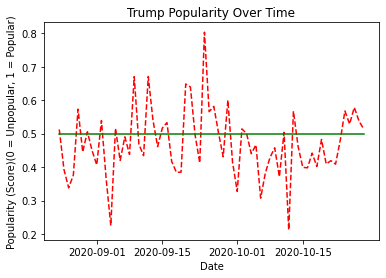

<Figure size 36000x14400 with 0 Axes>

In [ ]:
graph(trump_table, 'Trump')

Analysis:

To analyze their popularity across the months, we will be looking at the avergae daily sentiment for the candidates. As it can be seen from the graph above, Trump has a fluctating sentiment (But mostly negative) in the end of August and begining of September, and even reaches a low sentiment of almost 0.2. However, he manages to reach a peak in positive sentiment around the end of September, reaching around 0.8, which was around the time he was appointing a new Supreme Court Justice. Not surprisingly, after rushing a Justice, his leak of $750 taxes, and refusal to commit to a peaceful transition, his sentiment went negative significantly again, reaching again arounf 0.2 around the begining of October (Which is also arond when the presidential debates started). Nonetheless, he was able to recover to a normal sentiment at the end.

**Biden Sentiment Score Over Time**

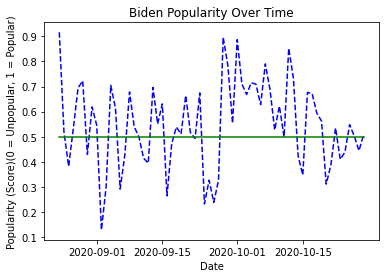

<Figure size 36000x14400 with 0 Axes>

In [ ]:
graph(biden_table, 'Biden')

Analysis:

As seen from the graph, Biden has a great start in the begining, starting from almost a 0.9. However, it soon starts fluctuating again, and reaches an all-time minimum at almost 0.1 in the begining of September. This may have been caused by the republicans attacking his stance to defund the police, and also the fact that he had stated around that time, that he would not ban fracking (something democrats probably did not like to hear). Nonetheless, he keeps fluctuating (more negative than positive) until late Spetember, when the presidential debates started, and his sentiment started being positive consistently. Nearing the end, his sentiment started going to the neutral, just like Trump's sentiment. rendering the 2020 elections tighter and more uncertain.

**Both Graphs Combined (to facilitate the visualization of the fluctuating popularity between each candidate)**

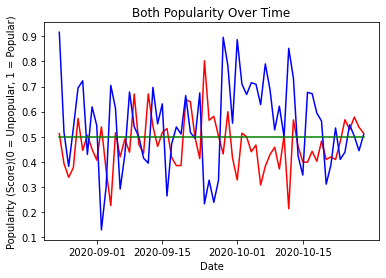

In [ ]:
td = trump_table['Date']
ts = trump_table['Score']
mid = trump_table['mid']

plt.plot(td,ts, color = 'red')
plt.xlabel('Date')
plt.ylabel('Popularity (Score)(0 = Unpopular, 1 = Popular)')
plt.title('Both Popularity Over Time')

bd = biden_table['Date']
bs = biden_table['Score']

plt.plot(bd,bs, color = 'blue')
plt.plot(td, mid, color = 'green')


**J. Most Common Words for Each Candidate**

In [ ]:
def bags(tw):
  bags = (bag_of_words(stop_words(clean_tweet(lower_tweet(tw)))))
  return (bags)

trump_bag = pd.DataFrame()

biden_bag = pd.DataFrame()


In [ ]:
#Filtering to the top 50 words

trump_50 = trump_bag.nlargest(50, 'Count')

biden_50 = biden_bag.nlargest(50, 'Count')

In [ ]:
#Checking the columns
trump_50.columns

Index(['Unnamed: 0', 'Count'], dtype='object')

**Trump Word Cloud**

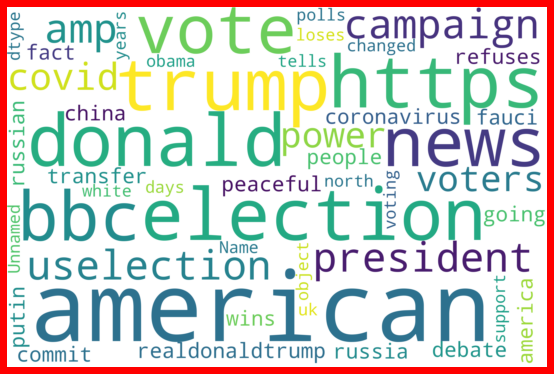

In [ ]:
trump_wc = WordCloud(width = 3000, height = 2000, background_color = 'white').generate(str(trump_50['Unnamed: 0']))

fig = plt.figure(
    figsize = (10, 5),
    facecolor = 'red',
    edgecolor = 'red')
plt.imshow(trump_wc, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

**Biden Word Cloud**

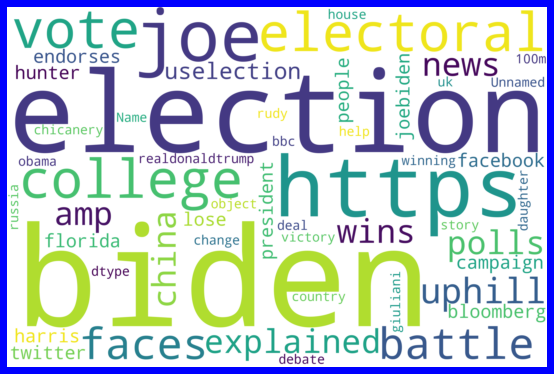

<function matplotlib.pyplot.cla>

In [ ]:
biden_wc = WordCloud(width = 3000, height = 2000, background_color = 'white').generate(str(biden_50['Unnamed: 0']))

fig = plt.figure(
    figsize = (10, 5),
    facecolor = 'blue',
    edgecolor = 'blue')
plt.imshow(biden_wc, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
plt.cla